## 重新整理一下
## 数据读取

In [ ]:
# Colab 专有命令
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/My\ Drive/Colab Notebooks/Lesson7\ RNN

In [14]:
from io import open
import glob
import os
import matplotlib.pyplot as plt
import unicodedata
import string
import numpy as np
import time
import math
import random
import torch
import torch.nn as nn

In [2]:
def find_files(path): return glob.glob(path)

print(find_files('data/names/*.txt'))

all_letters = string.ascii_letters + " .,;'"
n_letters = len(all_letters)

# Turn a Unicode string to plain ASCII, thanks to https://stackoverflow.com/a/518232/2809427
def unicode_2_Ascii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s) 
        if unicodedata.category(c) != 'Mn' and c in all_letters
    )

print(unicode_2_Ascii('Ślusàrski'))

['data/names\\Arabic.txt', 'data/names\\Chinese.txt', 'data/names\\Czech.txt', 'data/names\\Dutch.txt', 'data/names\\English.txt', 'data/names\\French.txt', 'data/names\\German.txt', 'data/names\\Greek.txt', 'data/names\\Irish.txt', 'data/names\\Italian.txt', 'data/names\\Japanese.txt', 'data/names\\Korean.txt', 'data/names\\Polish.txt', 'data/names\\Portuguese.txt', 'data/names\\Russian.txt', 'data/names\\Scottish.txt', 'data/names\\Spanish.txt', 'data/names\\Vietnamese.txt']
Slusarski


In [3]:
# Build the category_lines dictionary, a list of names per language
category_lines = {}
all_categories = []

# Read a file and split into lines
def read_lines(filename):
    lines = open(filename, encoding='utf-8').read().strip().split('\n')
    return [unicode_2_Ascii(line) for line in lines]

for filename in find_files('data/names/*.txt'):
    category = os.path.splitext(os.path.basename(filename))[0]
    all_categories.append(category)
    lines = read_lines(filename)
    category_lines[category] = lines

n_categories = len(all_categories)
print(n_categories)

18


## 查看训练时间方法

In [4]:
def time_since(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)


In [5]:
def category_from_output(output):
    top_n, top_i = output.topk(1)
    category_i = top_i[0].item()
    return all_categories[category_i], category_i


## 数据采样

In [6]:
# Find letter index from all_letters, e.g. "a" = 0 
def letter_to_index(letter):
    return all_letters.find(letter)

# 将一个词转成tensor，shape（1，词的字母数， 字母数（n_letters））
def line_to_tensor(line):
    tensor = torch.zeros(len(line), 1, n_letters)
    for li, letter in enumerate(line):
        tensor[li][0][letter_to_index(letter)] = 1
    return tensor

# 将多个词转成tensor，shape（词数，最长词的字母数， 字母数（n_letters））
def lines_to_tensor(lines):
    tensor = torch.zeros(len(lines[0]), len(lines), n_letters)
    for i, line in enumerate(lines):
        for li, letter in enumerate(line):
            tensor[li][i][letter_to_index(letter)] = 1
    return tensor

def sample(l):
    return l[random.randint(0, len(l) - 1)]

def sample_trainning(n_batch):
    categories = [sample(all_categories) for i in range(n_batch)]
    lines = [sample(category_lines[category]) for category in categories]
    max_lines_count = np.max([len(item) for item in lines])
    lines = [' '*(max_lines_count - len(line)) + line for line in lines]
    
    categories_tensor = torch.tensor([all_categories.index(category) for category in categories], dtype=torch.long)
    lines_tensor = lines_to_tensor(lines)
    return categories, lines, categories_tensor, lines_tensor

for i in range(10):
    categories, lines, categories_tensor, lines_tensor = sample_trainning(4)
    print('categories =', categories, '/ lines =', lines) 


NameError: name 'torch' is not defined

##训练方法

In [25]:
# 适用于RNN GRU
def _train_model(model, category_tensor, line_tensor, lossObj, device, optimizer, n_batch):
    hidden = model.initHidden(n_batch)

    for i in range(line_tensor.size()[0]):
        char_tensor = line_tensor[i].to(device)
        hidden = hidden.to(device)
        output, hidden = model(char_tensor, hidden)

    loss = lossObj(output.to(device), category_tensor.to(device))

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    return output, loss.item()

def categories_from_output(output):
    top_n, top_i = output.topk(1,dim=1)
    category_i_S = top_i.reshape(-1)
    return np.array([all_categories[category_i] for category_i in category_i_S]), category_i_S.cpu().data.numpy()

def train_process(model, learning_rate, n_iters, print_every, plot_every, n_batch,
                  train_model_func = _train_model, 
                  lossObj = nn.CrossEntropyLoss()):
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate) 
   
    # Keep track of losses for plotting
    current_loss = 0
    all_losses = []
    
    start = time.time()
    
    for iter in range(1, n_iters + 1):
        categories, lines, categories_tensor, lines_tensor = sample_trainning(n_batch)
        output, loss = train_model_func(model, categories_tensor, lines_tensor, lossObj, device, optimizer, n_batch)
        current_loss += loss
    
        # Print iter number, loss, name and guess
        if iter % print_every == 0:
            guess, guess_i = categories_from_output(output)
            correct = '✓' if guess[0] == categories[0] else '✗ (%s)' % categories[0]
            correct_count = len([item for item in (guess == categories) if item == True])
            print('%d %d%% (%s) %.4f acc=%.4f %s / %s %s' % \
                  (iter, iter / n_iters * 100, time_since(start), loss, correct_count / n_batch, lines[0], guess[0], correct))
    
        # Add current loss avg to list of losses
        if iter % plot_every == 0:
            all_losses.append(current_loss / plot_every)
            current_loss = 0
    
    return model, all_losses

# 评估方法

In [15]:
def evaluate(model, line_tensor, n_batch):
    hidden = model.initHidden(n_batch)

    for i in range(line_tensor.size()[0]):
        output, hidden = model(line_tensor[i], hidden)

    return output

def predict(model, input_line, evaluate_func = evaluate, n_predictions=3):
    print('\n> %s' % input_line)
    model = model.cpu()

    model.eval()
    with torch.no_grad():
        output = evaluate_func(model, line_to_tensor(input_line), 1)

        # Get top N categories
        topv, topi = output.topk(n_predictions, 1)
        predictions = []

        for i in range(n_predictions):
            value = topv[0][i].item()
            category_index = topi[0][i].item()
            print('(%.2f) %s' % (value, all_categories[category_index]))
            predictions.append([value, all_categories[category_index]])

def get_train_acc(model, evaluate_func = evaluate):
    model.eval()
    all_correct_count = 0
    all_line_count = 0
    for category in all_categories:
        correct_count = 0
        for line in category_lines[category]:
            output = evaluate_func(model, line_to_tensor(line), 1)
            topv, topi = output.topk(1, 1)
            category_index = topi[0][0].item()
            if all_categories[category_index] == category :
                correct_count += 1
                all_correct_count += 1
        sub_all_line_count = len(category_lines[category])
        all_line_count += sub_all_line_count
        print('%s 总个数：%d, 正确个数: %d, acc: %.4f'\
              %(category, sub_all_line_count , correct_count, correct_count/sub_all_line_count))
    print('所有分类总个数：%d, 正确个数: %d, acc: %.4f'\
              %(all_line_count, all_correct_count, all_correct_count/all_line_count))


In [16]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# device = torch.device('cpu')
print(device)

cuda


In [17]:
%matplotlib inline

## 上一部分用到的模型


In [18]:
class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN, self).__init__()

        self.hidden_size = hidden_size

        self.i2h = nn.Linear(input_size + hidden_size, hidden_size)
        self.i2o = nn.Linear(input_size + hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, input, hidden):
        combined = torch.cat((input, hidden), 1)
        hidden = self.i2h(combined)
        output = self.i2o(combined)
        output = self.softmax(output)
        return output, hidden

    def initHidden(self, n_batch):
        return torch.zeros(n_batch, self.hidden_size)

class GRU(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(GRU, self).__init__()

        self.hidden_size = hidden_size

        self.sigmoid = nn.Sigmoid()
        self.tanh = nn.Tanh()
        self.r_gate = nn.Linear(input_size + hidden_size, hidden_size)
        self.z_gate = nn.Linear(input_size + hidden_size, hidden_size)
        self.h_gate = nn.Linear(input_size + hidden_size, hidden_size)
        self.i2o = nn.Linear(hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, input:torch.Tensor, hidden:torch.Tensor):
        combined = torch.cat((input, hidden), 1)
        r = self.sigmoid(self.r_gate(combined))
        z = self.sigmoid(self.z_gate(combined))
        combined2 = torch.cat((r * hidden, input), 1)
        h_hat = self.tanh(self.h_gate(combined2))
        hidden = (1-z) * hidden + z * h_hat
        output = self.softmax(self.i2o(hidden))
        return output, hidden

    def initHidden(self, n_batch):
        return torch.zeros(n_batch, self.hidden_size)

### 3. 把该RNN模型变成多层RNN模型，观察Loss的变化

> todo

In [19]:
class RNN_module(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN_module, self).__init__()

        self.hidden_size = hidden_size

        self.i2h = nn.Linear(input_size + hidden_size, hidden_size)
        self.i2o = nn.Linear(input_size + hidden_size, output_size)

    def forward(self, input, hidden):
        combined = torch.cat((input, hidden), 1)
        hidden = self.i2h(combined)
        output = self.i2o(combined)
        return output, hidden

# 串联RNN
class SeriesRNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(SeriesRNN, self).__init__()

        self.hidden_size = hidden_size

        self.rnn1 = RNN_module(input_size, hidden_size, hidden_size)
        self.rnn2 = RNN_module(hidden_size, hidden_size, hidden_size)
        self.activation1 = nn.Tanh()
        self.i2o = nn.Linear(hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, input, hidden):
        rnn1_output, hidden = self.activation1(self.rnn1(input, hidden))
        rnn2_output, hidden = self.activation1(self.rnn2(rnn1_output, hidden))
        
        output = self.i2o(rnn2_output)
        output = self.softmax(output)
        return output, hidden

    def initHidden(self, n_batch):
        return torch.zeros(n_batch, self.hidden_size)
    
# 并联RNN  (先并联再串联)
class ParallelRNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(ParallelRNN, self).__init__()

        self.hidden_size = hidden_size

        self.rnn1 = RNN_module(input_size, hidden_size, hidden_size)
        self.rnn2 = RNN_module(input_size, hidden_size, hidden_size)
        self.activation1 = nn.Tanh()
        self.activation2 = nn.Sigmoid()
        self.rnn3 = RNN_module(hidden_size , hidden_size , hidden_size)
        self.activation3 = nn.Tanh()
        self.i2o = nn.Linear(hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, input, hidden):
        rnn1_output, hidden1 = self.activation1(self.rnn1(input, hidden))
        rnn2_output, hidden2 = self.activation2(self.rnn2(input, hidden))
        
        output, hidden =  self.activation3(self.rnn3(rnn1_output + rnn2_output, hidden1 + hidden2))
        
        output = self.i2o(output)
        output = self.softmax(output)
        return output, hidden

    def initHidden(self, n_batch):
        return torch.zeros(n_batch, self.hidden_size)
    

In [22]:
# 构建模型 
n_hidden = 128
model = RNN(n_letters, n_hidden, n_categories)

In [23]:
model = torch.load("RNN")

RNN(
  (i2h): Linear(in_features=185, out_features=128, bias=True)
  (i2o): Linear(in_features=185, out_features=18, bias=True)
  (softmax): LogSoftmax()
)
评估

> Dovesky
(-1.92) Polish
(-2.29) Russian
(-2.54) Italian

> Jackson
(-2.25) Russian
(-2.34) Scottish
(-2.41) Greek

> Satoshi
(-2.14) Italian
(-2.14) Polish
(-2.47) Greek

> Liu
(-2.48) Greek
(-2.78) French
(-2.80) Scottish

> Sun
(-2.62) Chinese
(-2.69) Korean
(-2.69) Scottish

> Tian
(-2.54) Irish
(-2.55) Arabic
(-2.59) Scottish
Arabic 总个数：2000, 正确个数: 289, acc: 0.1445
Chinese 总个数：268, 正确个数: 72, acc: 0.2687
Czech 总个数：519, 正确个数: 21, acc: 0.0405
Dutch 总个数：297, 正确个数: 128, acc: 0.4310
English 总个数：3668, 正确个数: 30, acc: 0.0082
French 总个数：277, 正确个数: 4, acc: 0.0144
German 总个数：724, 正确个数: 65, acc: 0.0898
Greek 总个数：203, 正确个数: 182, acc: 0.8966
Irish 总个数：232, 正确个数: 33, acc: 0.1422
Italian 总个数：709, 正确个数: 560, acc: 0.7898
Japanese 总个数：991, 正确个数: 338, acc: 0.3411
Korean 总个数：94, 正确个数: 12, acc: 0.1277
Polish 总个数：139, 正确个数: 60, acc: 0.4317
Portugu

C:\Users\fuliu\.conda\envs\pytorch\lib\site-packages\torch\serialization.py:360: UserWarning: Couldn't retrieve source code for container of type RNN. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


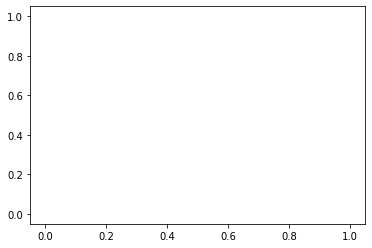

In [27]:
print(model)
model.train()
model = model.to(device)
# 超参数
learning_rate = 0.0001 # If you set this too high, it might explode. If too low, it might not learn
n_iters = 500000 # 这个数字你可以调大一些
print_every = 1000
plot_every = 100
n_batch = 8
# 训练
model, all_losses = train_process(model, learning_rate, n_iters, print_every, plot_every, n_batch)
torch.save(model, "RNN")
# 评估
print("评估")
predict(model, 'Dovesky')
predict(model, 'Jackson')
predict(model, 'Satoshi')
predict(model, 'Liu')
predict(model, 'Sun')
predict(model, 'Tian')
plt.plot(all_losses)
get_train_acc(model)

In [28]:
# 构建模型 
n_hidden = 128
model = SeriesRNN(n_letters, n_hidden, n_categories)

In [ ]:
model = torch.load("SeriesRNN")

In [29]:
print(model)
model.train()
model = model.to(device)
# 超参数
learning_rate = 0.0001 # If you set this too high, it might explode. If too low, it might not learn
n_iters = 500000 # 这个数字你可以调大一些
print_every = 1000
plot_every = 100
n_batch = 8
# 训练
model, all_losses = train_process(model, learning_rate, n_iters, print_every, plot_every, n_batch)
torch.save(model, "SeriesRNN")
# 评估
print("评估")
predict(model, 'Dovesky')
predict(model, 'Jackson')
predict(model, 'Satoshi')
predict(model, 'Liu')
predict(model, 'Sun')
predict(model, 'Tian')
plt.plot(all_losses)
get_train_acc(model)

SeriesRNN(
  (rnn1): RNN_module(
    (i2h): Linear(in_features=185, out_features=128, bias=True)
    (i2o): Linear(in_features=185, out_features=128, bias=True)
  )
  (rnn2): RNN_module(
    (i2h): Linear(in_features=256, out_features=128, bias=True)
    (i2o): Linear(in_features=256, out_features=128, bias=True)
  )
  (i2o): Linear(in_features=128, out_features=18, bias=True)
  (softmax): LogSoftmax()
)
1000 0% (0m 31s) 2.0459 acc=0.1250     Vitali / Japanese ✗ (Italian)


KeyboardInterrupt: 

In [30]:
# 构建模型 
n_hidden = 128
model = ParallelRNN(n_letters, n_hidden, n_categories)

In [ ]:
model = torch.load("ParallelRNN")

In [31]:
print(model)
model.train()
model = model.to(device)
# 超参数
learning_rate = 0.0001 # If you set this too high, it might explode. If too low, it might not learn
n_iters = 500000 # 这个数字你可以调大一些
print_every = 1000
plot_every = 100
n_batch = 8
# 训练
model, all_losses = train_process(model, learning_rate, n_iters, print_every, plot_every, n_batch)
torch.save(model, "ParallelRNN")
# 评估
print("评估")
predict(model, 'Dovesky')
predict(model, 'Jackson')
predict(model, 'Satoshi')
predict(model, 'Liu')
predict(model, 'Sun')
predict(model, 'Tian')
plt.plot(all_losses)
get_train_acc(model)

ParallelRNN(
  (rnn1): RNN_module(
    (i2h): Linear(in_features=185, out_features=128, bias=True)
    (i2o): Linear(in_features=185, out_features=128, bias=True)
  )
  (rnn2): RNN_module(
    (i2h): Linear(in_features=185, out_features=128, bias=True)
    (i2o): Linear(in_features=185, out_features=128, bias=True)
  )
  (rnn3): RNN_module(
    (i2h): Linear(in_features=256, out_features=128, bias=True)
    (i2o): Linear(in_features=256, out_features=128, bias=True)
  )
  (i2o): Linear(in_features=128, out_features=18, bias=True)
  (softmax): LogSoftmax()
)
1000 0% (0m 49s) 2.1366 acc=0.1250       Tse / Vietnamese ✗ (Chinese)


KeyboardInterrupt: 

### 4. Pytorch里边常用nn.NLLoss来代替crossentropy，将criterion改为nn.NLLoss，观察变化

> todo

In [32]:
# 构建模型 
n_hidden = 128
model = RNN(n_letters, n_hidden, n_categories)

In [ ]:
model = torch.load("RNN_NLLLoss")

In [33]:
print(model)
model.train()
model = model.to(device)
# 超参数
learning_rate = 0.0001 # If you set this too high, it might explode. If too low, it might not learn
n_iters = 500000 # 这个数字你可以调大一些
print_every = 1000
plot_every = 100
n_batch = 8
# 训练
model, all_losses = train_process(model, learning_rate, n_iters, print_every, plot_every, n_batch, lossObj=nn.NLLLoss())
torch.save(model, "RNN_NLLLoss")
# 评估
print("评估")
predict(model, 'Dovesky')
predict(model, 'Jackson')
predict(model, 'Satoshi')
predict(model, 'Liu')
predict(model, 'Sun')
predict(model, 'Tian')
plt.plot(all_losses)
get_train_acc(model)

RNN(
  (i2h): Linear(in_features=185, out_features=128, bias=True)
  (i2o): Linear(in_features=185, out_features=18, bias=True)
  (softmax): LogSoftmax()
)
1000 0% (0m 15s) 2.6043 acc=0.0000    Faltysek / Dutch ✗ (Czech)


KeyboardInterrupt: 

In [34]:
# 构建模型 
n_hidden = 128
model = GRU(n_letters, n_hidden, n_categories)

In [ ]:
model = torch.load("GRU_NLLLoss")

In [ ]:
print(model)
model.train()
model = model.to(device)
# 超参数
learning_rate = 0.0001 # If you set this too high, it might explode. If too low, it might not learn
n_iters = 500000 # 这个数字你可以调大一些
print_every = 1000
plot_every = 100
n_batch = 8
# 训练
model, all_losses = train_process(model, learning_rate, n_iters, print_every, plot_every, n_batch, lossObj=nn.NLLLoss())
torch.save(model, "GRU_NLLLoss")
# 评估
print("评估")
predict(model, 'Dovesky')
predict(model, 'Jackson')
predict(model, 'Satoshi')
predict(model, 'Liu')
predict(model, 'Sun')
predict(model, 'Tian')
plt.plot(all_losses)
get_train_acc(model)
















GRU(
  (sigmoid): Sigmoid()
  (tanh): Tanh()
  (r_gate): Linear(in_features=185, out_features=128, bias=True)
  (z_gate): Linear(in_features=185, out_features=128, bias=True)
  (h_gate): Linear(in_features=185, out_features=128, bias=True)
  (i2o): Linear(in_features=128, out_features=18, bias=True)
  (softmax): LogSoftmax()
)
1000 0% (0m 48s) 2.5251 acc=0.1250  Pefanis / Greek ✓
2000 0% (1m 38s) 2.5398 acc=0.1250  Szczepanski / Greek ✗ (Polish)
3000 0% (2m 29s) 2.1822 acc=0.5000         Baz / Chinese ✗ (Arabic)
4000 0% (3m 18s) 2.0209 acc=0.2500  Danas / Arabic ✗ (Greek)
5000 1% (4m 5s) 2.2317 acc=0.2500       Adam / Arabic ✗ (French)
6000 1% (4m 58s) 1.6154 acc=0.3750      Bing / Chinese ✓
7000 1% (5m 45s) 1.4228 acc=0.6250  Kalakos / Greek ✓
8000 1% (6m 34s) 1.8847 acc=0.1250     Kieu / Vietnamese ✓
9000 1% (7m 21s) 1.6930 acc=0.5000 Jarzembowski / Polish ✗ (Czech)
10000 2% (8m 14s) 0.9468 acc=0.6250     Varvitsiotes / Greek ✓
